# Estimation of the CTA point source sensitivity

## Introduction

This notebook explains how to estimate the CTA sensitivity for a point-like IRF at a fixed zenith angle and fixed offset using the full containement IRFs distributed for the CTA 1DC. The significativity is computed for a 1D analysis (On-OFF regions) and the LiMa formula. 

We use here an approximate approach with an energy dependent integration radius to take into account the variation of the PSF. We will first determine the 1D IRFs including a containment correction. 

We will be using the following Gammapy class:

* [gammapy.spectrum.SensitivityEstimator](https://docs.gammapy.org/dev/api/gammapy.spectrum.SensitivityEstimator.html)

## Setup
As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle
from gammapy.irf import load_cta_irfs
from gammapy.spectrum import SensitivityEstimator, CountsSpectrum

## Define analysis region and energy binning

Here we assume a source at 0.7 degree from pointing position. We perform a simple energy independent extraction for now with a radius of 0.1 degree.

In [3]:
offset = Angle("0.5 deg")

energy_reco = np.logspace(-1.8, 1.5, 20) * u.TeV
energy_true = np.logspace(-2, 2, 100) * u.TeV

## Load IRFs

We extract the 1D IRFs from the full 3D IRFs provided by CTA. 

In [4]:
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(filename)
arf = irfs["aeff"].to_effective_area_table(offset, energy=energy_true)
rmf = irfs["edisp"].to_energy_dispersion(
    offset, e_true=energy_true, e_reco=energy_reco
)
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)

## Determine energy dependent integration radius

Here we will determine an integration radius that varies with the energy to ensure a constant fraction of flux enclosure (e.g. 68%). We then apply the fraction to the effective area table.

By doing so we implicitly assume that energy dispersion has a neglible effect. This should be valid for large enough energy reco bins as long as the bias in the energy estimation is close to zero.

In [5]:
containment = 0.68
energy = np.sqrt(energy_reco[1:] * energy_reco[:-1])
on_radii = psf.containment_radius(energy=energy, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

In [6]:
arf.data.data *= containment

## Estimate background 

We now provide a workaround to estimate the background from the tabulated IRF in the energy bins we consider.  

In [7]:
bkg_data = irfs["bkg"].evaluate_integrate(
    fov_lon=0 * u.deg, fov_lat=offset, energy_reco=energy_reco
)
bkg = CountsSpectrum(
    energy_reco[:-1], energy_reco[1:], data=(bkg_data * solid_angles)
)

## Compute sensitivity

We impose a minimal number of expected signal counts of 5 per bin and a minimal significance of 3 per bin. We assume an alpha of 0.2 (ratio between ON and OFF area).
We then run the sensitivity estimator.

In [8]:
sensitivity_estimator = SensitivityEstimator(
    arf=arf, rmf=rmf, bkg=bkg, livetime="5h", gamma_min=5, sigma=3, alpha=0.2
)
sensitivity_table = sensitivity_estimator.run()

## Results

The results are given as an Astropy table. A column criterion allows to distinguish bins where the significance is limited by the signal statistical significance from bins where the sensitivity is limited by the number of signal counts.
This is visible in the plot below.

In [9]:
# Show the results table
sensitivity_table

energy,e2dnde,excess,background,criterion
TeV,erg / (cm2 s),,,
float64,float64,float64,float64,str12
0.0193572,3.77783e-11,142.553,1826.68,significance
0.0288753,1.06474e-11,220.607,4420.97,significance
0.0430735,7.74203e-12,180.228,2938.04,significance
0.0642532,4.22421e-12,111.985,1118.13,significance
0.0958471,1.73696e-12,75.5441,499.549,significance
0.142976,1.23576e-12,50.3005,215.216,significance
0.213279,8.1623e-13,31.6252,80.8063,significance
0.31815,5.57432e-13,20.7149,32.1657,significance


In [10]:
# Save it to file (could use e.g. format of CSV or ECSV or FITS)
# sensitivity_table.write('sensitivity.ecsv', format='ascii.ecsv')

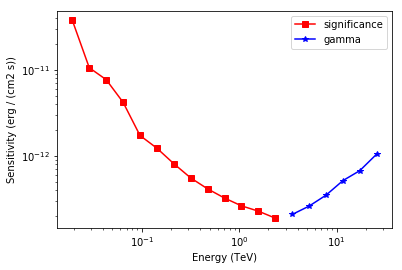

In [11]:
# Plot the sensitivity curve
t = sensitivity_estimator.results_table

is_s = t["criterion"] == "significance"
plt.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s-",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
plt.plot(
    t["energy"][is_g], t["e2dnde"][is_g], "*-", color="blue", label="gamma"
)

plt.loglog()
plt.xlabel("Energy ({})".format(t["energy"].unit))
plt.ylabel("Sensitivity ({})".format(t["e2dnde"].unit))
plt.legend();

We add some control plots showing the expected number of background counts per bin and the ON region size cut (here the 68% containment radius of the PSF).

(0.01, 0.5)

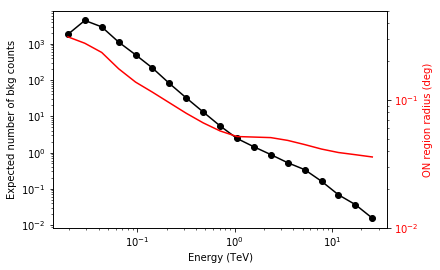

In [12]:
# Plot expected number of counts for signal and background
fig, ax1 = plt.subplots()
# ax1.plot( t["energy"], t["excess"],"o-", color="red", label="signal")
ax1.plot(
    t["energy"], t["background"], "o-", color="black", label="blackground"
)

ax1.loglog()
ax1.set_xlabel("Energy ({})".format(t["energy"].unit))
ax1.set_ylabel("Expected number of bkg counts")

ax2 = ax1.twinx()
ax2.set_ylabel("ON region radius ({})".format(on_radii.unit), color="red")
ax2.semilogy(t["energy"], on_radii, color="red", label="PSF68")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0.01, 0.5)

## Exercises

* Also compute the sensitivity for a 20 hour observation
* Compare how the sensitivity differs between 5 and 20 hours by plotting the ratio as a function of energy.